In [1]:
from os import chdir
chdir("../general")
from models import *
chdir("../case-studies")
from fenics import *
import numpy as np
from numpy import random
from scipy import sparse
from scipy.sparse import linalg as splinalg
import matplotlib.pyplot as plt

In [2]:
# We will assume only one application here
alpha = 2

# the rest of the parameters
d = 1
nu = alpha - d/2
kappa = 0.5
rho = np.sqrt(8*nu)/kappa
tau = 1
sigma2 = 1
sigma2_anal = analytical_matern_var(nu,kappa,d)
print(rho)

6.928203230275509


In [3]:
# Create mesh and define function space
xL = 0
xR = 30
expand = 15
num_pt = 750
mesh = IntervalMesh(num_pt,xL-expand,xR+expand)
V = FunctionSpace(mesh, 'P', 1)
fem = V.element()

u = TrialFunction(V)
v = TestFunction(V)
stiffness = kappa**2*u*v*dx + inner(grad(u), grad(v))*dx
mass = inner(u,v)*dx

In [4]:
# Assemble precision matrices
K = assemble(stiffness)
K = as_backend_type(K).mat()
K = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)

Lapp = sparse.spdiags(L.sum(axis=0),0,m,n)
invL = sparse.spdiags(1/L.sum(axis=0),0,m,n) # the approx from Lindgren
sqrt_invL = sparse.spdiags(1/np.sqrt(L.sum(axis=0)),0,m,n)

In [5]:
# the problem
N = int(1e4)
dt = 3e-3
M = sparse.eye(m) - dt*invL @ K

In [6]:
import time

start = time.time()
print(N,m)
sim = random.normal(size=(N,m))
sim0 = np.zeros((N,m))
sim1 = np.zeros((N,m))
sim2 = np.zeros((N,m))
for i in range(N):
	sim0[i,:] = sqrt_invL @ sim[i,:]
sim1[0,:] = sim0[0,:]
for i in range(1,N):
	sim1[i,:] = M @ sim1[i-1,:] + sim0[i,:]
sim1 *= dt
sim2[0,:] = sim1[0,:]
for i in range(1,N):
	sim2[i,:] = M @ sim2[i-1,:] + sim1[i,:]
sim2 *= dt
end = time.time()
print(end-start)

10000 751
0.8763887882232666


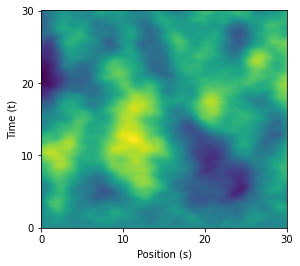

In [7]:
plt.imshow(sim2[list(reversed((range(0,N,20)))),:][:,range(93,658)])
plt.xticks([0,188,377,566],["0","10","20","30"])
plt.yticks([0,167,333,500],["30","20","10","0"])
plt.xlabel("Position (s)")
plt.ylabel("Time (t)")
plt.savefig("../figs/matern_xt.png")

# start = time.time()
# R = sparse.eye(N*m) - sparse.kron(sparse.diags(np.ones(N-1),-1),M)
# R_white = sparse.kron(sparse.eye(N),sqrt_invL)
# sim = random.normal(size=N*m)
# sim0 = R_white @ sim
# sim1 = dt*splinalg.spsolve_triangular(R,sim0)
# sim_1xt = np.reshape(sim1,(N,m))
# sim2 = dt*splinalg.spsolve_triangular(R,sim1)
# sim_2xt = np.reshape(sim2,(N,m))
# end = time.time()
# print(end-start)